In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.10.0+cu111
GPU 사용 가능 여부: False


In [2]:
batch_size = 100
epochs = 5
learning_rate = 0.001
iteration = 5000 // batch_size

In [3]:
root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dataset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dataset.FashionMNIST(root=root, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



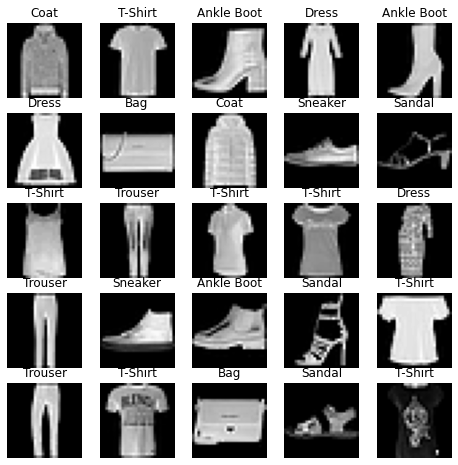

In [4]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy()
    label = labels_map[train_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

In [6]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        print(m.weight)

In [7]:
model = DNN().to(device)
model.apply(weights_init)

Parameter containing:
tensor([[ 0.0031, -0.0055,  0.0091,  ...,  0.0113,  0.0208, -0.0100],
        [-0.0737, -0.0135,  0.0142,  ..., -0.0218,  0.0078,  0.0016],
        [-0.0182, -0.0434, -0.0596,  ..., -0.0422,  0.0087,  0.0432],
        ...,
        [ 0.0389, -0.0396, -0.0286,  ..., -0.0566, -0.0493,  0.0459],
        [ 0.0467, -0.0436,  0.0062,  ..., -0.0219, -0.0175,  0.0161],
        [-0.0298,  0.0035, -0.0546,  ...,  0.0074,  0.0283,  0.0240]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0874, -0.0589,  0.0743,  ..., -0.0337,  0.0773, -0.0109],
        [ 0.0159, -0.0649, -0.0381,  ..., -0.0410,  0.0188, -0.0195],
        [-0.0769, -0.0371,  0.0537,  ...,  0.0618,  0.0282, -0.0699],
        ...,
        [ 0.0622,  0.0172,  0.0559,  ..., -0.0792, -0.0307, -0.0660],
        [-0.0214,  0.0451, -0.0505,  ...,  0.0758, -0.0551, -0.0485],
        [ 0.0170, -0.1144,  0.0174,  ..., -0.0975,  0.0124,  0.0205]],
       requires_grad=True)


DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        outputs = model(data)

        loss = criterion(outputs, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % iteration == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

In [10]:
def test():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, argmax = torch.max(outputs, 1)
            total += data.size(0)
            correct += (target == argmax).sum().item()
        
        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

In [11]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.566637
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.423715
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.427877
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.520174
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.399946
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.509731
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.324794
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.331195
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.555988
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.382160
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.352715
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.385174
Test accuracy for 10000 images: 86.03%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.353521
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.304940
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.463127
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.387401
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.317283
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.492251
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.474495
Train Epoch: 2 [35000/600

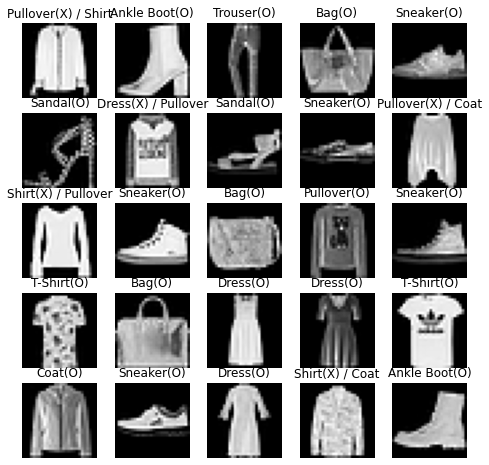

In [12]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()